# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.random import RandomGenerator

import pandas as pd

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict, enable_errors=True) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if enable_errors and np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, observables=[])

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1, enable_errors=False)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'f1': 0.11401572022703582,
 'xopt_runtime': 0.20049182600001814,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = pd.DataFrame({
    "x":np.linspace(0,1,10),
    "y":np.linspace(0,1,10)
})
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.000000,0.300571,False,NaN
1,0.024691,0.100351,False,NaN
2,0.098765,0.200537,False,NaN
3,0.222222,0.400671,False,NaN
4,0.395062,0.300563,False,NaN
5,0.617284,0.400680,False,NaN
6,0.888889,0.100350,False,NaN
7,1.209877,0.400642,False,NaN
8,NaN,0.100789,True,"Traceback (most recent call last):\n File ""/u..."
9,NaN,0.300685,True,"Traceback (most recent call last):\n File ""/u..."


In [10]:
# Dataframe submission (returns futures dict)
futures = ev.submit_data(in10)
for future in futures:
    print(future.result())

{'f1': 0.0, 'xopt_runtime': 0.20044872400001168, 'xopt_error': False}
{'f1': 0.024691358024691357, 'xopt_runtime': 0.40065248299998757, 'xopt_error': False}
{'f1': 0.09876543209876543, 'xopt_runtime': 0.10034816699999283, 'xopt_error': False}
{'f1': 0.2222222222222222, 'xopt_runtime': 0.30053619000000253, 'xopt_error': False}
{'f1': 0.3950617283950617, 'xopt_runtime': 0.10034826700001531, 'xopt_error': False}
{'f1': 0.617283950617284, 'xopt_runtime': 0.4006593530000373, 'xopt_error': False}
{'f1': 0.8888888888888888, 'xopt_runtime': 0.20044122799998831, 'xopt_error': False}
{'f1': 1.2098765432098761, 'xopt_runtime': 0.3005563910000433, 'xopt_error': False}
{'xopt_runtime': 0.10049026999996613, 'xopt_error': True, 'xopt_error_str': 'Traceback (most recent call last):\n  File "/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/utils.py", line 137, in safe_call\n    result = func(*args, **kwargs)\n  File "/tmp/ipykernel_2943/4275037860.py", line 6, in f\n    raise ValueE

In [11]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


,xopt_runtime,xopt_error,xopt_error_str
0,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
1,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
2,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
3,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
4,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
5,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
6,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
7,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
8,0.20119,True,"Traceback (most recent call last):\n File ""/u..."
9,0.20119,True,"Traceback (most recent call last):\n File ""/u..."


In [12]:
# Vectorized submission. This returns a single future.
ev.vectorized = True
futures = ev.submit_data(in10)
len(futures)

1

In [13]:
futures[0].result()

{'xopt_runtime': 0.2005801319999705,
 'xopt_error': True,
 'xopt_error_str': 'Traceback (most recent call last):\n  File "/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/utils.py", line 137, in safe_call\n    result = func(*args, **kwargs)\n  File "/tmp/ipykernel_2943/4275037860.py", line 6, in f\n    raise ValueError("x > 0.8")\nValueError: x > 0.8\n'}

In [14]:
# Collect in a dataframe
res = futures[0].result()
# If there is an error, all outputs are spoiled.
if res['xopt_error']:
    res = [res]
pd.DataFrame(res)

,xopt_runtime,xopt_error,xopt_error_str
0,0.20058,True,"Traceback (most recent call last):\n File ""/u..."


# Executors

In [15]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
MAX_WORKERS = 10

In [16]:
# Create Executor insance
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [17]:
# Dask (Optional)
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [18]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS)

In [19]:
# This will run in parallel
ev.evaluate_data(in10)

,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.000000,0.200932,False,NaN
1,0.024691,0.201170,False,NaN
2,0.098765,0.201328,False,NaN
3,0.222222,0.201485,False,NaN
4,0.395062,0.201650,False,NaN
5,0.617284,0.201807,False,NaN
6,0.888889,0.201979,False,NaN
7,1.209877,0.202143,False,NaN
8,NaN,0.202710,True,"Traceback (most recent call last):\n File ""/u..."
9,NaN,0.203347,True,"Traceback (most recent call last):\n File ""/u..."


# Evaluator in the Xopt object

In [20]:
X = Xopt(generator=RandomGenerator(vocs=vocs), evaluator=Evaluator(function=f),
         vocs=vocs)
X.options.strict = False

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
1,0.844488,0.232588
2,0.265390,0.046769
3,0.268404,0.709026
4,0.142141,0.152218


In [21]:
# Internal futures dictionary
X._futures

{1: <Future at 0x7f0125a39550 state=finished returned dict>,
 2: <Future at 0x7f0125a6fb50 state=finished returned dict>,
 3: <Future at 0x7f0125a6f460 state=finished returned dict>,
 4: <Future at 0x7f0125a0f9a0 state=finished returned dict>}

In [22]:
# Collect all finished futures and updata dataframe
X.process_futures()
X.data

,x,y,xopt_runtime,xopt_error,xopt_error_str,f1
1,0.844488,0.232588,0.300810,True,"Traceback (most recent call last):\n File ""/u...",NaN
2,0.265390,0.046769,0.200428,False,NaN,0.072619
3,0.268404,0.709026,0.300558,False,NaN,0.574759
4,0.142141,0.152218,0.400651,False,NaN,0.043374


In [23]:
# Futures are now cleared out
X._futures

{}

In [24]:
# This is the internal counter
X._ix_last

4

In [25]:
# This causes immediate evaluation
X.evaluate_data(vocs.random_inputs(4))

,x,y,f1,xopt_runtime,xopt_error,xopt_error_str
5,0.705105,0.723537,1.020680,0.300620,False,NaN
6,0.475619,0.532415,0.509679,0.300680,False,NaN
7,0.057461,0.684185,0.471410,0.400642,False,NaN
8,0.925261,0.609837,NaN,0.400774,True,"Traceback (most recent call last):\n File ""/u..."


In [26]:
# Singe generation step
X.step()
X.data

,x,y,xopt_runtime,xopt_error,xopt_error_str,f1
1,0.844488,0.232588,0.300810,True,"Traceback (most recent call last):\n File ""/u...",NaN
2,0.265390,0.046769,0.200428,False,NaN,0.072619
3,0.268404,0.709026,0.300558,False,NaN,0.574759
4,0.142141,0.152218,0.400651,False,NaN,0.043374
5,0.705105,0.723537,0.300620,False,NaN,1.020680
6,0.475619,0.532415,0.300680,False,NaN,0.509679
7,0.057461,0.684185,0.400642,False,NaN,0.471410
8,0.925261,0.609837,0.400774,True,"Traceback (most recent call last):\n File ""/u...",NaN
9,0.333263,0.127120,0.200444,False,NaN,0.127224


In [27]:
# Usage with a parallel executor. 
X2 = Xopt(
    generator=RandomGenerator(vocs=vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True
X2.options.strict = False

In [28]:
X2.step()

In [29]:
for _ in range(20):
    X2.step()

len(X2.data)

58

<Axes: xlabel='x', ylabel='y'>

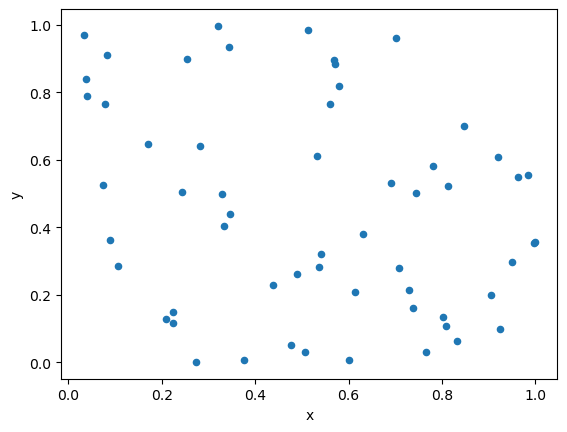

In [30]:
X2.data.plot.scatter("x", "y")

In [31]:
# Asynchronous, Vectorized
X2 = Xopt(
    generator=RandomGenerator(vocs=vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True
X2.evaluator.vectorized = True
X2.options.strict = False

# This takes fewer steps to achieve a similar number of evaluations
for _ in range(3):
    X2.step()

len(X2.data)

30